In [1]:
import matplotlib.pyplot as plt
import numba
import numpy as np

In [2]:
# Lattice vectors
a = 2.46
c = 6.71
lat_vec = a * np.array([
    [3**0.5/2, -1/2, 0],
    [3**0.5/2, 1/2, 0],
    [0, 0, c/a]
])
a1, a2, a3 = lat_vec

# Sublattice offsets
basis = np.array([
    [0, 0, 0],
    [a/3**0.5, 0, 0],
    [0, 0, c/2],
    [-a/3**0.5, 0, c/2],
])


# Reciprocal lattice vectors
rec_vec = 2*np.pi*np.linalg.inv(lat_vec).T
b1, b2, b3 = rec_vec


# High-symmetry points
G = np.array([0., 0., 0.])
K = (b1 + 2*b2)/3
M = (b1 + b2)/2
A = b3/2
L = A + M
H = A + K

In [7]:
@numba.njit
def make_rmesh(N, offset=G):
    """Make a coordinate mesh grid.

    r[:,n,i,j] = i * a1 + j * a2 + R_n + offset

    Parameters
    ----------
    N1, N2 : int
        Number of sites.
    lat_vec : ndarray
    offset : ndarray
        Offset of vectors.

    Returns
    -------
    rs : ndarray
        Coordinates.
    """
    rs = np.empty((3, 2, N, N))
    f = np.arange(N)
    f[N//2:] -= N
    for n in range(2):
        for i in range(N):
            for j in range(N):
                rs[:,n,i,j] = f[i]*a1 + f[j]*a2 + basis[n] + offset
    return rs


@numba.njit
def make_kmesh(N, offset=G, tile=1):
    """Make a k-mesh grid on the trapezoidal Brillouin zone.

    k[:,i,j] = i/N1 * b1 + j/N2 * b2 + offset

    Parameters
    ----------
    N1, N2 : int
        Number of k-points.
    offset : ndarray
        Offset of vectors.
    tile : int
        Number of BZ repetitions.

    Returns
    -------
    ks : ndarray
        k vectors.
    """
    b1 = rec_vec[0]
    b2 = rec_vec[1]
    ks = np.empty((3, tile*N, tile*N))
    for i in range(tile*N):
        for j in range(tile*N):
            ks[:,i,j] = i/N * b1 + j/N * b2 + offset
    return ks

In [8]:
V = 1.
delta = 0.01
Nk = 512
nr = np.load(f'HOPG_B2_nr_{Nk}x{Nk}_V{V}_Gamma{delta}.npy')
print(nr.shape)

(2, 512, 512)


In [9]:
x, y, z = make_rmesh(Nk)

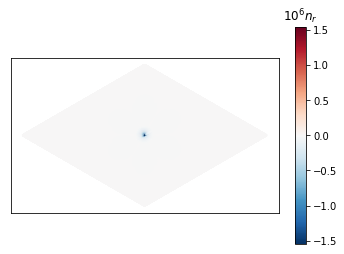

In [10]:
c = 1e6*nr
vmax = np.abs(c).max()

fig, ax = plt.subplots()
s = ax.scatter(x, y, s=1, c=c, vmin=-vmax, vmax=vmax, cmap='RdBu_r')
#ax.set_xlim(-50, 50)
#ax.set_ylim(-50, 50)
ax.set_aspect(1)
ax.set_xticks([])
ax.set_yticks([])
cb = fig.colorbar(s, ax=ax)
cb.ax.set_title(r'$10^6 n_r$')

plt.show()

The coordinates and momenta are
$$ r = n_1 a_1 + n_2 a_2 + R_n $$
$$ q = \frac{m_1}{N} b_1 + \frac{m_2}{N} b_2 $$
$$ q \cdot r = \frac{2\pi}{N} (m_1 n_1 + m_2 n_2) + q \cdot R_n $$

The Fourier transform is
$$ A_q = \sum_r a_r e^{-iqr} \\
= \sum_{n, n_1, n_2} a_r \exp\left( -2\pi i(m_1 n_1 + m_2 n_2) - iq \cdot R_n \right) \\
= \sum_n e^{-iq \cdot R_n} \sum_{n_1, n_2} a_r \exp\left( -\frac{2\pi i}{N} (m_1 n_1 + m_2 n_2) \right) $$
I.e. the Fourier transform is the sum of the DFT of each sublattice with a phase offset.

In [50]:
# Tile FT


tileNum = 4
q = make_kmesh(Nk, -tileNum/2*(b1+b2), tileNum)
nq = np.tile(np.fft.fft2(nr), (tileNum, tileNum))
#nq = np.tile(np.fft.fftshift(np.fft.fft2(nr)), (tileNum, tileNum))
Z = np.zeros((tileNum*Nk, tileNum*Nk), complex)

for i in range(2):
    # Sum FT with offset phase
    Z += nq[i] * np.exp(-1j * (q[0] * basis[i,0] + q[1] * basis[i,1]))

/Users/jiatongyang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


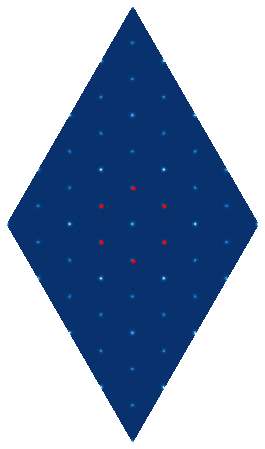

In [51]:
xmax = 4*np.pi/(3**0.5*a)
ymax = 2*np.pi/a

fig, ax = plt.subplots(figsize=(8,8))
im = ax.pcolormesh(q[0], q[1], np.abs(Z), vmin=0, cmap='Blues_r', rasterized=True)
ax.set_aspect(1)
#ax.set_xlim(-xmax, xmax)
#ax.set_ylim(-ymax, ymax)
K = np.array([(b1 + 2*b2)/3, (-b1 + b2)/3, (b2 + 2*b1)/3, -(b1 + 2*b2)/3, -(-b1 + b2)/3, -(b2 + 2*b1)/3])
ax.plot(K[:,0], K[:,1], 'r.')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
plt.savefig(f"../../data/FT_debug/figures/tile{tileNum}.png")